# Fashion MNSIT Final Project


<h2 id="Preparation" >Preparation</h2>


In [1]:
# !pip install torch
# !pip install torchvision
# !pip install matplotlib

In [2]:
# PyTorch Modules you need for this lab

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
torch.manual_seed(0)

In [3]:
# Other non-PyTorch Modules

from matplotlib.pyplot import imshow
import matplotlib.pylab as plt

from PIL import Image

### Helper Function

In [4]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

### Downloading Dataset and Applying the Transforms


In [5]:
IMAGE_SIZE = 16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [6]:
train_dataset = dsets.FashionMNIST(root='.fashion/data', train=True, transform=composed, download=True)
validation_dataset = dsets.FashionMNIST(root='.fashion/data', train=False, transform=composed, download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 16817118.49it/s]


Extracting .fashion/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to .fashion/data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 257373.56it/s]


Extracting .fashion/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to .fashion/data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3350345.52it/s]


Extracting .fashion/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to .fashion/data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10441139.74it/s]


Extracting .fashion/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to .fashion/data/FashionMNIST/raw



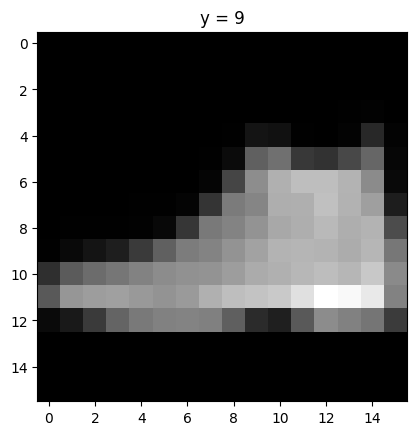

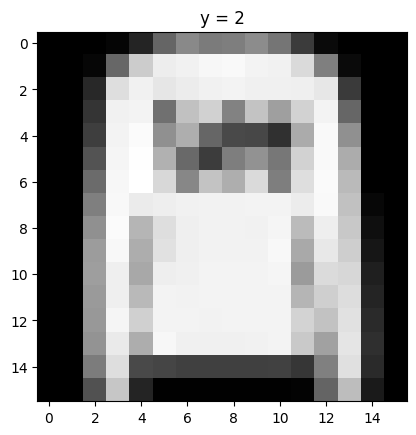

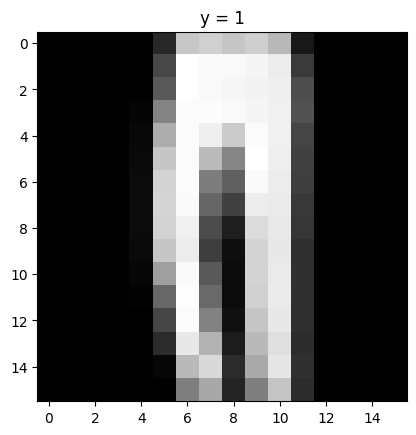

In [7]:
for n,data_sample in enumerate(validation_dataset):

    show_data(data_sample)
    plt.show()
    if n==2:
        break

### Convolutional Neural Networks

In [8]:
class CNN_batch(nn.Module):

    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100 )
test_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100 )

In [24]:
model = CNN_batch(out_1=16, out_2=32,number_of_classes=10)

In [25]:
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [26]:
import time
start_time = time.time()

cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
n_epochs=15
for epoch in range(n_epochs):
    cost=0
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        cost+=loss.item()
    correct=0
    #perform a prediction on the validation  data
    model.eval()
    for x_test, y_test in test_loader:
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
    cost_list.append(cost)


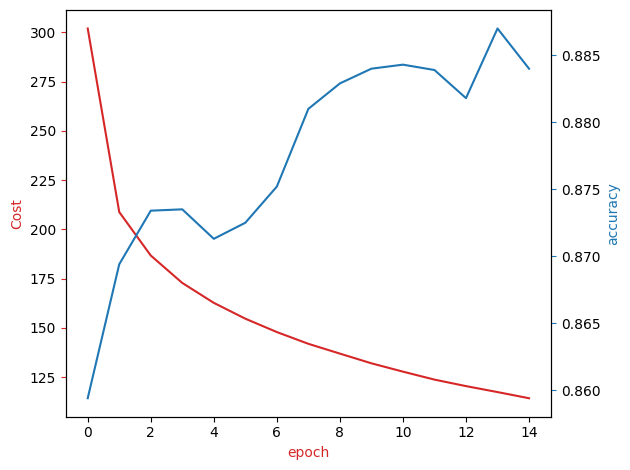

In [27]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()